# Laboratório 01 - fast.ai DL1 2019 Brasília


### Introdução

Bem vindos ao primeiro laboratório da turma fast.ai DL1 2019. O objetivo do laboratório é consolidar os conhecimentos obtidos nas aulas 01 e 02, bem como promover debate, discussões relacionadas ao tema, bem como fazer com que a maioria coloque a "mão na massa" como gosta nosso guru, Jeremy.

Realizaremos nesse laboratório o treinamento de uma rede neural para classificação de expressões faciais baseadas em fotos de pessoas. Utilizaremos a base de dados de um desafio do Kaggle de 2013, conforme detalhes mais adiante. O modelo treinado terá alcançado uma acurácia similiar, ou até superior, aos melhores modelos da competição em 2013. Além disso, vamos desenvolver um aplicativo web simples para colocar em produção nosso modelo treinado de a nos permitir testar novas imagens com expressões a avaliar a acurácia da rede neural na prática.

Esse notebook é uma combinação de dois posts do colega [Pierre Guillou](https://www.linkedin.com/in/pierreguillou/), que cedeu seu código para que possamos consolidar nossos conhecimentos:

- [Face Expression Recognition with fastai v1](https://medium.com/@pierre_guillou/face-expression-recognition-with-fastai-v1-dc4cf6b141a3).
- [Deep Learning Web App by fastai v1](https://medium.com/@pierre_guillou/deep-learning-web-app-by-fastai-v1-3ab4c20b7cac)


### Reconhecimento de Expressões Faciais (Face Expression Recognition Kaggle Challenge - FER 2013) com fastai v1

by: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou/) (novembro 2018)  
    [Leon Silva](https://www.linkedin.com/in/leonsolon/) (tradução/atualização março 2019)
    [Vinícius Ramos](https://www.linkedin.com/in/vinicius-ramos-6a367073/) (atualização/deploy no Django na GCP março 2018)

- Inspirado por [Recognizing Facial Expressions Using Deep Learning](http://cs231n.stanford.edu/reports/2017/pdfs/224.pdf) (2017) of Alexandru Savoiu and James Wong (Stanford University)
- Base de dados : [FER 2013 Kaggle Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/)
- Deep Learning utilizando [fastai v1](https://www.fast.ai/2018/10/02/fastai-ai/)

# Inicialização

Vamos começar como todo e qualquer notebook que utiliza fast.ai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

# Configuração da API Kaggle

Faremos o download do banco de imagens diretamente do Kaggle. Para tal, é necessário seguir os passos abaixo. Este notebook está focalizado na google cloud platform (GCP), tendo em vista que a maioria da turma realizou essa instalação. Se você está lendo isso é porque já está rodando o jupyter de alguma forma, seja na máquina local, seja no gcp, portanto, pularemos os passos de inicialização da instância e do jupyter.

1. Caso ainda não possua, cria sua conta no [Kaggle](https://www.kaggle.com) no seu computador local
2. No canto superior direito, clique na sua foto (ou avatar) e selecione 'My account'
3. Selecione a opção 'Create API Token'. 
4. Ao selecionar a opção será baixado um arquivo na sua máquina, chamada `kaggle.json`. Esse arquivo contém as credenciais da API do Kaggle (nome de usuário e senha)
5. Abra o arquivo `kaggle.json` no seu editor de textos preferido e copie o conteúdo. Cole o conteúdo na célula abaixo, no local indicado.

In [3]:
# Comando que cria a pasta Kaggle em /home/<seu_usuario>. Essa pasta é necessária para conter a chave de API do Kaggle
!mkdir ~/.kaggle

# Esse comando cria o arquivo kaggle.json na instância no local correto: /home/<seu_usuario/.kaggle/kaggle.json
!echo '{"username":"leonsolon","key":"72e608eaed282a6b86a1f35e87d9b6f7"}' >> ~/.kaggle/kaggle.json

# Por questões de segurança, garanta que outros usuários do seu computador não tenham acesso de leitura 
# às suas credenciais. Esse comando é necessário, do contrário a API do Kaggle se recusa a fazer o download das bases de dados.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Com a chave de API do Kaggle, agora é a vez de instalar a API do kaggle
!sudo pip install kaggle

### Termos da competição

Um passo importante, antes de baixar os dados do Kaggle é aceitar os termos da competição. Para isso, acesse a seção `rules` na [página da competição](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/rules) e clique em `I Understand and Accept`

# Dados

## Download do Kaggle

Agora que temos a conta, chave de API e pacote instalado, basta realizarmos o download das imagens com as expressões faciais direto do kaggle. 

In [3]:
# Comando para alterar pasta para '~/.fastai/data', onde os arquivos serão armazenados. 
%cd ~/.fastai/data/

# Finnalmente, download do arquivo FER 2013 a partir da conta do Kaggle (fer2013.tar.gz)
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

/home/leonsolon/.fastai/data


In [6]:
# Use os comandos abaixo para criar uma pasta para FER (face expression recognition)
# e para descompactar o arquivo dentro da pasta FER
!mkdir FER
!mv fer2013.tar.gz FER
!rm example_submission.csv
!tar -xvf FER/fer2013.tar.gz -C FER

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


## Listando arquivos

In [4]:
# Verificar se os arquivos foram decompactados corretamente
%cd ~/.fastai/data/
PATH = Path('./FER/fer2013')
PATH.ls()

/home/leonsolon/.fastai/data


[PosixPath('FER/fer2013/models'),
 PosixPath('FER/fer2013/valid'),
 PosixPath('FER/fer2013/test'),
 PosixPath('FER/fer2013/fer2013.csv'),
 PosixPath('FER/fer2013/README'),
 PosixPath('FER/fer2013/fer2013.bib'),
 PosixPath('FER/fer2013/train')]

In [5]:
# Nessa competição, as imagens foram armazenadas em forma de pixels, com os valores RGB de cada
# A 1a coluna apresenta a emoção (expressão) a qual a imagem representa
# A 2a coluna apresenta a imagem em si, num arranjo de números RFB que representa os pixels
# A 3a coluna traz a utilidade da imagem, se será utilizada para treinamento, teste público ou teste privado (detalhes mais adiante).
df = pd.read_csv(PATH/'fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
# As expressões das imagens na descrição do desafio do Kaggle, de 0 a 6 são
# Raiva, Nojo, Medo, Alegria, Tristeza, Surpresa, Neutro
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
for l in range(len(labels)):
    print(f'{l} = {labels[l]}')

0 = Angry
1 = Disgust
2 = Fear
3 = Happy
4 = Sad
5 = Surprise
6 = Neutral


In [7]:
# Também temos a utilização das imagens, treinamento, teste público e teste privado 
# Os desafios Kaggle possuem um teste público, com a base que disponibilizam para criação dos modelos
# e uma privada que somente é testada com a submissão dos resultados
usages = df['Usage'].unique();usages

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [8]:
# Vamos separar os data frames em treinamento, teste público e teste privado
df_train = df[df['Usage'] == 'Training']
df_valid = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# Os tamanhos de cada data frame
n_train = len(df_train)
n_valid = len(df_valid)
n_test = len(df_test)
n = len(df)

print(f'{n_train} (Training) + {n_valid} (PublicTest) + {n_test} (PrivateTest) = {n} images')

28709 (Training) + 3589 (PublicTest) + 3589 (PrivateTest) = 35887 images


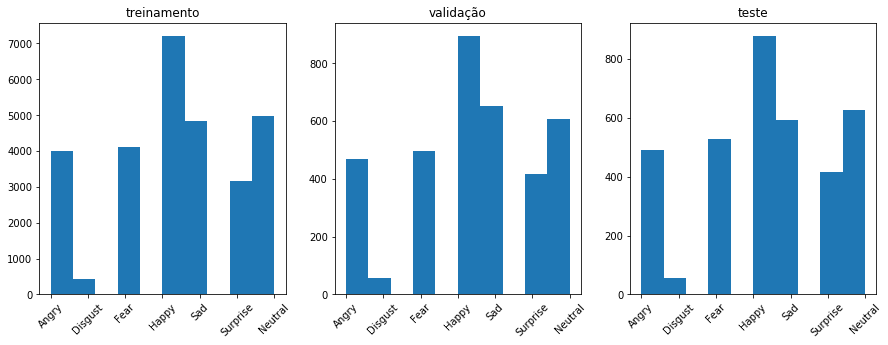

In [9]:
# histograma das bases de treinamento, teste público e teste privado
def setup_axe(axe,df,title):
    axe.hist(df['emotion'])
    axe.set_xticks(list(range(len(labels))))
    axe.set_xticklabels(labels, rotation=45)
    axe.set_title(title)

fig, axes = plt.subplots(1,3, figsize=(15,5))
setup_axe(axes[0],df_train,'treinamento')
setup_axe(axes[1],df_valid,'validação')
setup_axe(axes[2],df_test,'teste')
plt.show()

In [10]:
# Vamos avaliar a proporção das imagens na base de treinamento de cada uma das 7 expressões
ne = df_train['emotion'].value_counts(ascending=True)
for k,v in zip(ne.keys(),ne.values):
    pct = round(v/n*100,2)
    print(f'({pct}%) {v} {labels[k]}')

(1.21%) 436 Disgust
(8.84%) 3171 Surprise
(11.13%) 3995 Angry
(11.42%) 4097 Fear
(13.46%) 4830 Sad
(13.84%) 4965 Neutral
(20.1%) 7215 Happy


In [11]:
# A função abaixo recria a imagem a partir dos pixels. Lembrando que as imagens são sequências de 3 números para cada pixel, ex (48,48,3)
# Vamos representar a expressão como um inteiro e os pixels de uma imagem como um array numpy 
def row2image(row):
    pixels, emotion = row['pixels'], row['emotion']
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

# Apresenta imagem já convertida com o título da expressão
def show(img_title):
    plt.imshow(img_title[0])
    plt.title(labels[img_title[1]])

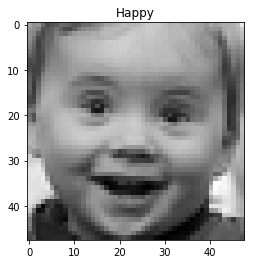

In [12]:
# Vamos dar uma olhada na base para ver as imagens? Brinquem à vontade, aqui não somos Gilberto Gil, mas vamos de 2222
row = df_train.iloc[2222]
img = row2image(row)
show(img)

# Armazenar os dados (pixels) em forma de imagens nas pastas train/val/test

In [13]:
# Com a função de pixels (com 3 números cada) para arquivos, vamos agora criar as pastas para armazenar cria as pastas train, valid e test
Path(PATH/'train').mkdir(exist_ok=True)
Path(PATH/'valid').mkdir(exist_ok=True)
Path(PATH/'test').mkdir(exist_ok=True)

In [14]:
# Define as variáveis das pastas de treinamento, teste público e teste privado
PATH_train = PATH/'train'
PATH_valid = PATH/'valid'
PATH_test = PATH/'test'

In [15]:
# cria as 7 pastas das expressões em cada uma das pastas train, train, val e test
for l in labels:
    Path(PATH_train/l).mkdir(exist_ok=True)
    Path(PATH_valid/l).mkdir(exist_ok=True)
    Path(PATH_test/l).mkdir(exist_ok=True)

In [16]:
# Cria as imagens a partir dos pixels e salva nas subpastas correspondentes. Aqui utilizaremos o teste público como validação
# e teste privado como teste
def createImages(df,path):
    for e in range(len(labels)):
        df_e = df[df['emotion'] == e]
        path_e = path/labels[e]
        i=0
        for index, row in df_e.iterrows():
            img = row2image(row)
            image = PIL.Image.fromarray(img[0], 'RGB')
            fname = str(e)+'_'+str(i)+'.jpg'
            image.save(path_e/fname)
            i += 1

In [20]:
# Calcula o tempo para criação das imagens e posicionamento nas subpastas
%%time
createImages(df_train,PATH_train)
createImages(df_valid,PATH_valid)
createImages(df_test,PATH_test)

CPU times: user 1min 36s, sys: 1.49 s, total: 1min 38s
Wall time: 1min 38s


In [17]:
# Vamos dar uma olhada se a criação ocorreu da forma desejada
p = PATH_train/'Angry'
p.ls()[:5]

[PosixPath('FER/fer2013/train/Angry/0_3571.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_2571.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_628.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_1527.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_1206.jpg')]

# Criar o ImageDataBunch parametrizado para resnet50

In [18]:
# Cria transformações para as imagens como forma de aumentar o dataset  data augmentation
tfms = get_transforms()

In [19]:
# ImageDataBunch
# bs=16, size=299 : ajustamos os parametros para o laboratório terminar num tempo razoável, mas o melhor seria o valor 
# do hiperparâmetro size=299 para ajudar à resnet50
data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, bs=16, size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Test: None

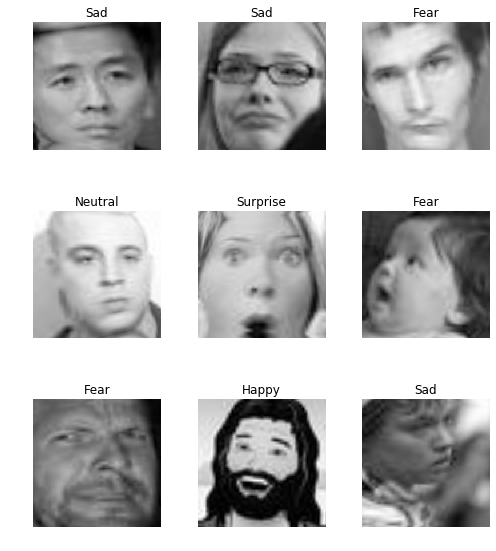

In [41]:
data.show_batch(rows=3, figsize=(7,8))

In [20]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
 7,
 28709,
 3589)

# Train model (resnet50)

In [21]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy])

In [44]:
learn.fit_one_cycle(4)



epoch,train_loss,valid_loss,accuracy,time
0,1.499939,1.446840,0.458345,05:00
1,1.296788,1.197734,0.545556,04:57
2,1.206872,1.126566,0.570075,04:58
3,1.139228,1.108432,0.574533,04:58


In [45]:
learn.save('fer2013-stage-1')

In [22]:
learn.load('fer2013-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [23]:
learn.export('fer2013-stage-1.pth')

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


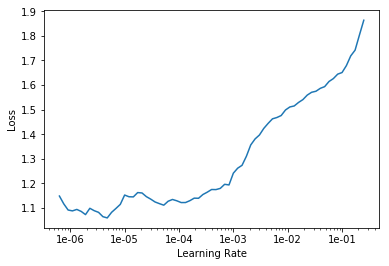

In [26]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.197570,1.090622,0.581220,06:54
1,1.105021,1.045216,0.609362,06:55
2,1.035570,1.007485,0.618557,06:56
3,0.972201,0.989539,0.629145,06:56
4,0.911745,0.967893,0.640847,06:56
5,0.910077,0.963010,0.645862,06:56
6,0.882154,0.959905,0.646420,06:56
7,0.828473,0.959452,0.643633,06:57


In [28]:
learn.save('fer2013-stage-2')
learn.export('modelo.pkl')

# Resultados

Com o modelo treinado, vamos avaliar os resultados, principalmente com relação a acurácia.

In [37]:
learn.load('fer2013-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

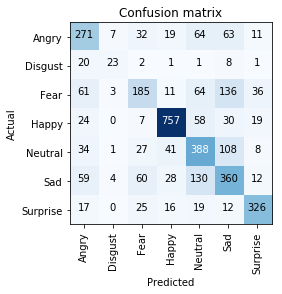

In [35]:
# A matriz de confusão mostra que, para as expressões com mais dados para treinamento temos um acerto maior
interp.plot_confusion_matrix()

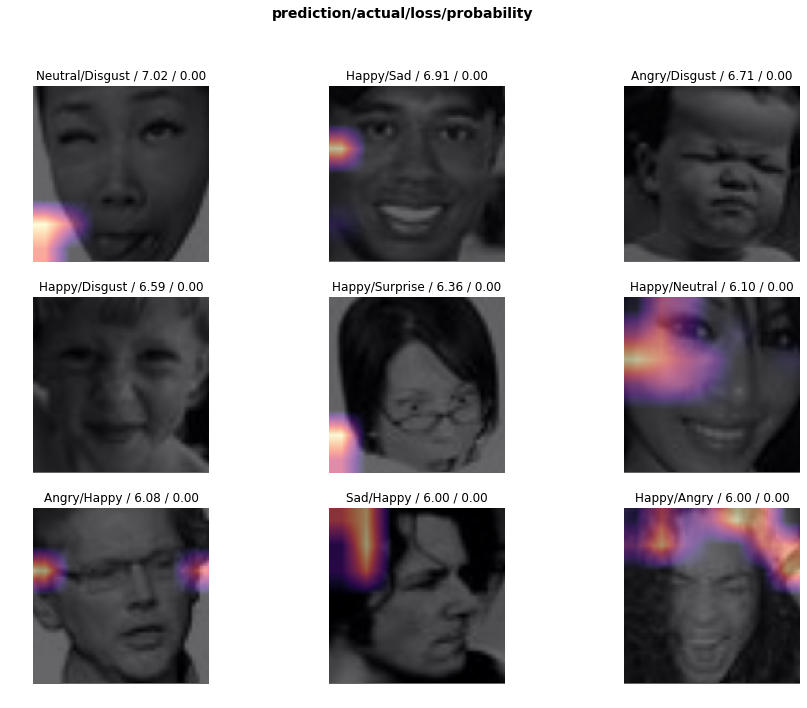

In [36]:
# Avaliando quais foram as piores classificações em termos de erro
interp.plot_top_losses(9, figsize=(15,11))

# Acurácia

In [38]:
val_probs, val_targets = learn.get_preds()

In [39]:
val_preds = torch.argmax(val_probs,1)

In [40]:
val_acc = (val_preds == val_targets).type(torch.FloatTensor).mean().item()
print(f'valid accuracy: {round(val_acc*100,2)}%')

valid accuracy: 64.36%


Apesar de parecer pouco, um modelo com 64% de acurácia estaria bem colocado no desafio do Kaggle, isso sem muito esforço, pois poderíamos melhorar o tamanho da imagem e realizar limpeza das imagens expúreas/dúbias.


# Utilizando o modelo em produção (predição de novas fotos)

Agora vamos testar nosso modelo com aquelas imagens que não foram utilizadas nem no treino nem na validação. Brinquem à vontade, alterando a pasta de 'Happy' para outras expressões, bem como o índice do array de arquivos.

In [41]:
data.classes

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

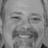

In [42]:
# get image from test folder (images arquived in subfolders)
p = PATH_test/'Happy'
url = p.ls()[1]
img = open_image(url)
img

In [43]:
# get prediction
#probs = learn.predict(img)
#prediction = learn.data.classes[probs.argmax()]
#prediction

pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Happy

## Buscando imagem da internet

Vamos tentar buscar uma imagem na internet e realizar uma classificação da expressão facial? 

--2019-03-29 06:03:30--  http://thesharpe.com/wp-content/uploads/2017/01/surprise-someone-1-1024x768.jpg
Resolving thesharpe.com (thesharpe.com)... 78.153.213.8, 2a01:a8:dc0:331::1a7
Connecting to thesharpe.com (thesharpe.com)|78.153.213.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96123 (94K) [image/jpeg]
Saving to: ‘surprise-someone-1-1024x768.jpg’

surprise-someone-1- 100%[===================>]  93.87K   216KB/s    in 0.4s    

2019-03-29 06:03:31 (216 KB/s) - ‘surprise-someone-1-1024x768.jpg’ saved [96123/96123]



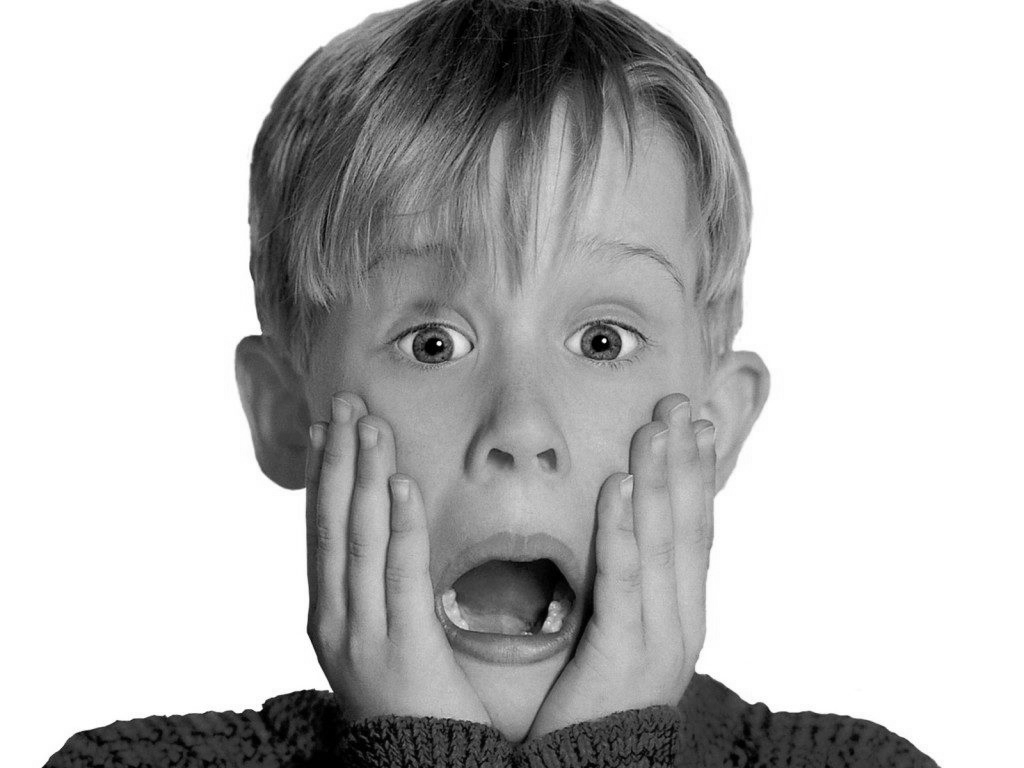

In [45]:
# Download da imagem
!wget http://thesharpe.com/wp-content/uploads/2017/01/surprise-someone-1-1024x768.jpg
    
# Transformação para grayscale (as imagens treinadas e validadas também estão em grayscale)
img = PIL.Image.open('surprise-someone-1-1024x768.jpg').convert('LA')

# Salvar a imagem (percebam que o formato deve ser png)
img.save('surprise-someone-1-1024x768.png')    
    
# Mudança de semântica! Antes img era uma imagem do pacote PIL, agora é uma imagem fast.ai (open_image)    
img = open_image('./surprise-someone-1-1024x768.png')

# Vamos dar uma olhada na imagem baixada em grayscale
img

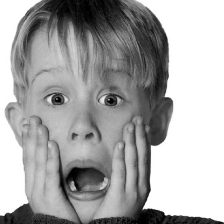

In [46]:
# Vamos realizar as transformações utilizadas nas imagens de treino? A imagem a ser classificada será reduzida e poderá
# sofrer algumas rotações e distorções
tfms = get_transforms()

for transformation in tfms:
    img = img.apply_tfms(transformation, size=224)

img

In [47]:
# finalmente, vamos prever o que o Kevin McCallister estava expressando
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Surprise

In [29]:
learn.export('fer-lab01.pth')